основная идея - отделять траверсу от остальных частей опоры по пплотности отражений.    

In [1]:
from pathlib import Path
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from numpy import unique
from numpy import where

In [2]:
p = Path(r'D:\python\some_tools\structure_samples\xyz')

In [3]:
list_of_files = list(p.glob('*.xyz'))
for file in list_of_files:
    print(file.name)

2pole_supp_guys.xyz
3pole_guys.xyz
d-pole_3x.xyz
pole-w-guys_near_substation.xyz
pole_asim_3.xyz
pole_asim_post.xyz
strain_2.xyz
strain_3_lean_lo.xyz
strain_A_dpole.xyz
strain_A_dpole_leaned.xyz
strain_big.xyz
strain_sm.xyz
substation.xyz
sus_2pole_lean.xyz
sus_big.xyz
sus_guyed_2x_steel.xyz
sus_w_wires.xyz
s_pole.xyz
s_pole_xarms.xyz


In [272]:
spam_file = p / 'strain_big.xyz'
str = []
with spam_file.open() as f:
        spamreader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_NONNUMERIC, skipinitialspace=True)
        for row in spamreader:
            str.append(row)
str[:5]

[[237.32, 459.25, 24.44],
 [236.8, 459.16, 24.52],
 [237.3, 459.15, 25.21],
 [237.11, 459.02, 24.85],
 [236.86, 458.97, 24.86]]

In [273]:
n_s = np.array(str)
n2 = n_s[:,:2]   # x and y
n2[:5]

array([[237.32, 459.25],
       [236.8 , 459.16],
       [237.3 , 459.15],
       [237.11, 459.02],
       [236.86, 458.97]])

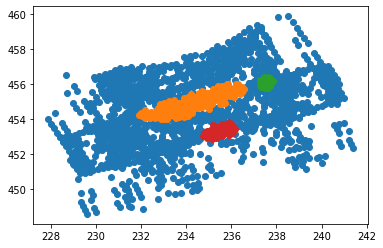

In [274]:
X = n2
clustering = DBSCAN(eps=0.3, min_samples=20).fit(X)
#print(clustering.labels_)

yhat = clustering.fit_predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	plt.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.show()

первая попытка сегментирования в плановом виде без учета высоты.
иногда стабатывает на выделения тела опоры (восновном столбов), но выходит не всегда удачно, особенно на сложных опорах.

далее попробую одномерные графики - плотность по высотной составляющей - должно лучше отделять траверсы (если они без сильного наклона)

In [275]:
n_z = n_s[:,2]
n_z[:5]

array([24.44, 24.52, 25.21, 24.85, 24.86])

In [276]:
zd = int(abs(n_z.min() - n_z.max())*2)  # z diff * 2 (to make one step = 0.5m)
zd

77

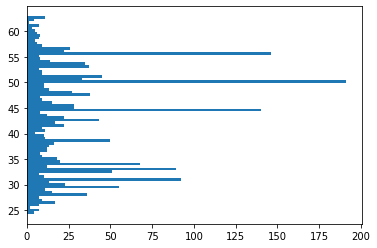

In [277]:
new_a = plt.hist(n_z, zd, orientation='horizontal')

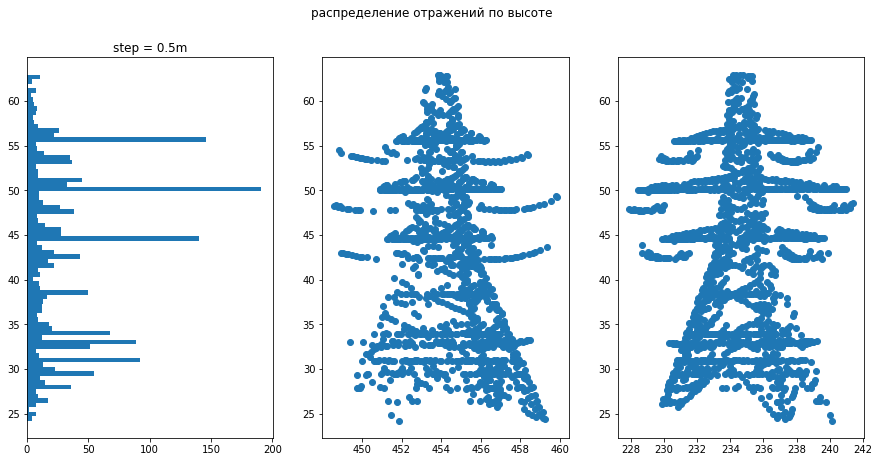

In [278]:
plt.figure(figsize=(15, 7))

plt.subplot(131)  # 1 строка, 3 колонки, 1 колонка
plt.title('step = 0.5m')
plt.hist(n_z, zd, orientation='horizontal')
plt.subplot(132)   # 1 строка, 3 колонки, 2 колонка
plt.plot(n_s[:,1], n_s[:,2], 'o')
plt.subplot(133)
plt.plot(n_s[:,0], n_s[:,2], 'o')

plt.suptitle('распределение отражений по высоте')
plt.show()

как видно на графике по плотности очень хорошо можно находить траверсы, особенно при большом количестве отражений от опоры. На столбах тоже хорошо работает. Дальше нужно будет выделить точки в пиках, и по этим массивам в плане построить прямую (линейную регрессию) которая будет означать угол разворота опоры.  в будущем этот подход позволит также определять нижние кромки траверс.


In [279]:
for a in new_a: print(len(a), a)

77 [  4.   7.   2.   7.  17.   9.   7.  36.  15.  11.  55.  23.  13.  92.
  10.   7.  51.  89.  12.  68.  20.  18.   9.   8.  12.  12.  13.  16.
  50.  11.  10.   5.  11.   9.  22.  17.  43.  22.  12.   8. 140.  28.
  28.  15.   9.   8.  38.  27.  13.  10.  10. 191.  33.  45.   9.   9.
   7.  37.  35.  14.   8.   7. 146.  22.  26.   9.   6.   5.   7.   8.
   6.   5.   3.   7.   1.   4.  11.]
78 [24.25       24.75285714 25.25571429 25.75857143 26.26142857 26.76428571
 27.26714286 27.77       28.27285714 28.77571429 29.27857143 29.78142857
 30.28428571 30.78714286 31.29       31.79285714 32.29571429 32.79857143
 33.30142857 33.80428571 34.30714286 34.81       35.31285714 35.81571429
 36.31857143 36.82142857 37.32428571 37.82714286 38.33       38.83285714
 39.33571429 39.83857143 40.34142857 40.84428571 41.34714286 41.85
 42.35285714 42.85571429 43.35857143 43.86142857 44.36428571 44.86714286
 45.37       45.87285714 46.37571429 46.87857143 47.38142857 47.88428571
 48.38714286 48.89      

In [280]:
len(new_a[0])//2, len(new_a[0])

(38, 77)

In [281]:
np.mean(new_a[0]), np.median(new_a[0])

(24.025974025974026, 12.0)

In [282]:
level = list(new_a[0]).index(max(new_a[0][(len(new_a[0])//2):]))

In [283]:
print(f'самая большая плотность обнаружена в диапазоне: {round(new_a[1][level], 1)} - {round(new_a[1][level+1], 1)}')
print(f'количество точек: {int(max(new_a[0][(len(new_a[0])//2):]))}')

самая большая плотность обнаружена в диапазоне: 49.9 - 50.4
количество точек: 191


In [284]:
ma = []
for nu, i in enumerate(list(new_a[0])):
    if nu > len(new_a[0])//2:
        if i > (np.mean(new_a[0]))*2:
            ma.append((nu, i))
        
print(ma)

[(40, 140.0), (51, 191.0), (62, 146.0)]
